### Digit Recognition Project

In [1]:
import numpy as np
import pandas as pd
import sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

### Loading and Exploring Data

In [2]:
labeled_images = np.load("data/labeled_images.npy")
labeled_digits = np.load("data/labeled_digits.npy")
autograder_images = np.load("data/autograder_images.npy")

In [3]:
# This is an array containing all the 3750 images of size 28 times 28 pixels:
labeled_images.shape

(3750, 28, 28)

Text(0, 0.5, 'Frequency')

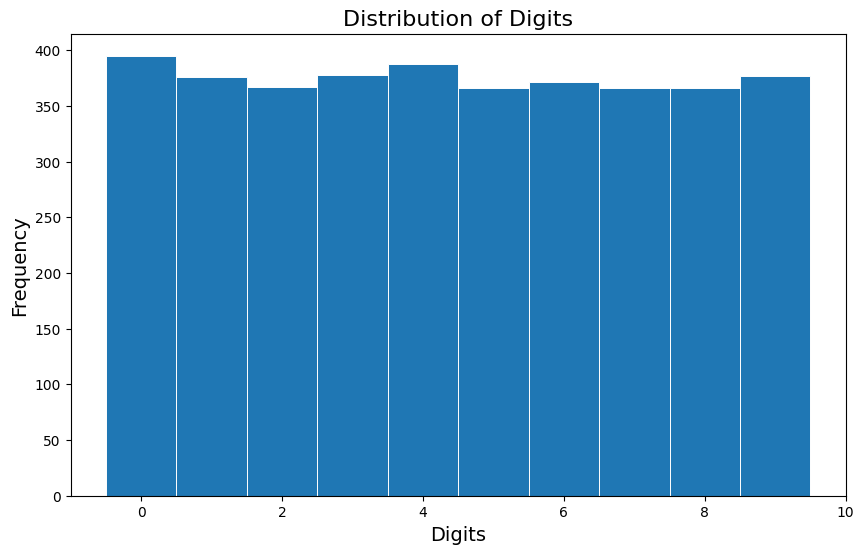

In [4]:
# Understanding the data distribution

digits, counts = np.unique(labeled_digits, return_counts=True)
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(digits, counts, width=1, edgecolor="white", linewidth=0.7)
ax.set_title('Distribution of Digits', fontsize=16)  
ax.set_xlabel('Digits', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14) 

# Observation: Equal distribution of classes (our classes are digits)

In [5]:
# This is an array containing the digit corresponding to each image:
labeled_digits[0:100]

array([1, 7, 0, 5, 2, 8, 4, 0, 4, 2, 2, 3, 4, 7, 2, 8, 0, 9, 2, 5, 4, 1,
       1, 6, 3, 6, 4, 9, 9, 7, 2, 4, 5, 1, 5, 7, 0, 4, 4, 6, 3, 0, 6, 5,
       0, 9, 7, 8, 0, 6, 1, 8, 4, 8, 9, 1, 4, 8, 0, 0, 7, 9, 1, 8, 9, 3,
       4, 9, 0, 5, 9, 6, 4, 0, 9, 4, 0, 6, 3, 1, 8, 9, 0, 8, 0, 1, 6, 4,
       4, 6, 1, 2, 7, 2, 0, 0, 5, 9, 2, 7])

### KNN Classifier
Following: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

Average Accuracy: 0.8561222222222222
5
Accuracy: 0.8786666666666667


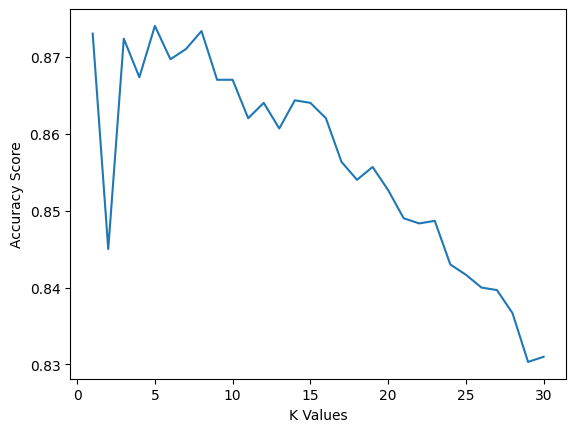

In [25]:
import statistics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

X = labeled_images.reshape(labeled_images.shape[0], -1)
y = labeled_digits
# train 80% test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k_values = [i for i in range(1, 31)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

# see relation between k values and accuracy
plt.plot(k_values, scores)
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
print("Average Accuracy:", statistics.mean(scores))

# choose the k value that maximizes accuracy
best_index = np.argmax(scores)
best_k = k_values[best_index]
print(best_k)

knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# k=5 -> accuracy 0.8786666666666667

### Prepare autograder submission

In the autograder you will need to provide two things: 1) estimate of the accuracy of your model on unseen data, 2) the predictions on the autograder images. For the autograder images we only provide the images and not the class labels. Thus, you cannot compute the accuracy on this data yourself - you need to estimate that with labeled data that is provided (labeled_images, labeled_digits). We will calculate the accuracy for you on the autograder data and you will receive an automatic grade based on this. 

In [26]:
estimate = np.array([0.86]) # TODO Replace this with your estimate of the accuracy on new data
#prediction = np.array([-1] * len(autograder_images)) # TODO Replace this with your predictions of your best model
auto_processed = autograder_images.reshape(autograder_images.shape[0], -1)
prediction = knn_clf.predict(auto_processed)
# For example using something like:
# prediction = my_super_duper_model.predict(autograder_images) 

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)